In [27]:
from etr.auto_import import *
from etr.core.fifo import calc_matching_table
from etr.data.data_loader import load_data

In [81]:
rate = load_data(date=["2025-05-01", "2025-05-31"], table="Rate", venue="coincheck", symbol="XRPJPY")

2025-06-07 20:01:18.567|INFO    |etr.data.data_loader: data_loader.load_data 85|Found 26 HDB files, process loading...
100%|██████████| 26/26 [00:00<00:00, 26.35it/s]


In [82]:
## BT Agg Rate
rate.market_created_timestamp = rate.market_created_timestamp.fillna(rate.timestamp)
rate_1s = (
    rate
    .set_index("market_created_timestamp", drop=False)
    .groupby(["sym", "venue"])[["best_bid", "best_ask"]]
    .resample("1s", label="right").last().unstack(level=[0, 1])
    .ffill().stack(level=[1, 2]).reset_index()
)
rate_bt = list(zip(rate_1s.market_created_timestamp, rate_1s.assign(_data_type="BT_Rate").to_dict(orient="records")))

In [85]:
# Rate feed
rate_feed = list(zip(rate.timestamp, rate.assign(_data_type="Rate").to_dict(orient="records")))

In [86]:
%%time
# Concatenate in one List[(timestamp, msg)]
messages = rate_feed + rate_bt
messages = sorted(messages, key=lambda x: x[0])

CPU times: user 334 ms, sys: 205 ms, total: 539 ms
Wall time: 640 ms


---

In [105]:
from etr.strategy.tod.tod_v1 import TOD_v1
from etr.core.api_client.backtest_client import BacktestClient

In [111]:
import logging

In [112]:
strategy.logger.setLevel(logging.CRITICAL)

In [113]:
## Backtest runner
client = BacktestClient("coincheck")
strategy = TOD_v1(
    venue="coincheck",
    client=client,
    entry_config=[
        {"sym": "XRPJPY", "start": datetime.time(1, 30), "holding_minutes": 60 * 4, "sl_level": 300, "side": 1, "amount": 1, "spread_filter": 20},
        {"sym": "XRPJPY", "start": datetime.time(7, 0), "holding_minutes": 60 * 5 + 30, "sl_level": 300, "side": 1, "amount": 1, "spread_filter": 20},
        {"sym": "XRPJPY", "start": datetime.time(16, 30), "holding_minutes": 60 * 4, "sl_level": 300, "side": 1, "amount": 1, "spread_filter": 20},
    ]
)
strategy.logger.setLevel(logging.CRITICAL)
strategy.warmup(now=messages[0][0])
client.register_strategy(strategy)

for t, msg in tqdm(messages):
    await strategy.client.on_message(msg)
    await strategy.on_message(msg)

  0%|          | 0/2567277 [00:00<?, ?it/s]

In [114]:
client.orders_frame

,timestamp,market_created_timestamp,sym,side,price,amount,executed_amount,order_type,order_status,venue,order_id,model_id,process_id,src_type,src_id,src_received_timestamp,misc,universal_id
0,2025-05-02 16:30:10.281934+00:00,NaT,XRPJPY,1,323.1840,1,0,market,new,coincheck,836fdaed8c2b40c5a9a2f330b8949420,TOD_v1,a867334a7a0a44f3bf89a845b7de5ad2,Rate,cfa81e48c8d6498bb4f446f0c1c6be51,2025-05-02 16:30:10.281934+00:00,entry 16:30:00+240M,836fdaed8c2b40c5a9a2f330b8949420
1,2025-05-02 16:30:11+00:00,2025-05-02 16:30:11+00:00,XRPJPY,1,323.2100,1,1,market,filled,coincheck,836fdaed8c2b40c5a9a2f330b8949420,TOD_v1,a867334a7a0a44f3bf89a845b7de5ad2,Rate,cfa81e48c8d6498bb4f446f0c1c6be51,2025-05-02 16:30:10.281934+00:00,entry 16:30:00+240M,836fdaed8c2b40c5a9a2f330b8949420
2,2025-05-02 20:31:57.188333+00:00,NaT,XRPJPY,-1,321.4205,1,0,market,new,coincheck,69b7e2cd6cdb4d8682267b46616361d0,TOD_v1,a867334a7a0a44f3bf89a845b7de5ad2,Rate,5575ff29eb964ac698b0acadbba57019,2025-05-02 20:31:57.188333+00:00,exit 16:30:00+240M,69b7e2cd6cdb4d8682267b46616361d0
3,2025-05-02 20:31:58+00:00,2025-05-02 20:31:58+00:00,XRPJPY,-1,321.3410,1,1,market,filled,coincheck,69b7e2cd6cdb4d8682267b46616361d0,TOD_v1,a867334a7a0a44f3bf89a845b7de5ad2,Rate,5575ff29eb964ac698b0acadbba57019,2025-05-02 20:31:57.188333+00:00,exit 16:30:00+240M,69b7e2cd6cdb4d8682267b46616361d0
4,2025-05-03 01:32:05.241983+00:00,NaT,XRPJPY,1,320.0580,1,0,market,new,coincheck,650145c5df1e4fe98e748e57f69c73c4,TOD_v1,a867334a7a0a44f3bf89a845b7de5ad2,Rate,5d2089380c74484289b877a499b19ff1,2025-05-03 01:32:05.241983+00:00,entry 01:30:00+240M,650145c5df1e4fe98e748e57f69c73c4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2025-05-27 05:30:44+00:00,2025-05-27 05:30:44+00:00,XRPJPY,-1,328.5520,1,1,market,filled,coincheck,bc521699d353434d8e89c32e87fc480e,TOD_v1,a867334a7a0a44f3bf89a845b7de5ad2,Rate,fd7cbe00649b46c6a773eeebe08349c1,2025-05-27 05:30:43.075169+00:00,exit 01:30:00+240M,bc521699d353434d8e89c32e87fc480e
260,2025-05-27 07:00:44.248969+00:00,NaT,XRPJPY,1,329.4670,1,0,market,new,coincheck,90257e813cdf4b0f9b0ea76794edfcef,TOD_v1,a867334a7a0a44f3bf89a845b7de5ad2,Rate,4cb3840b24934d019675fe1a785615b8,2025-05-27 07:00:44.248969+00:00,entry 07:00:00+330M,90257e813cdf4b0f9b0ea76794edfcef
261,2025-05-27 07:00:45+00:00,2025-05-27 07:00:45+00:00,XRPJPY,1,329.4350,1,1,market,filled,coincheck,90257e813cdf4b0f9b0ea76794edfcef,TOD_v1,a867334a7a0a44f3bf89a845b7de5ad2,Rate,4cb3840b24934d019675fe1a785615b8,2025-05-27 07:00:44.248969+00:00,entry 07:00:00+330M,90257e813cdf4b0f9b0ea76794edfcef
262,2025-05-27 12:31:36.319696+00:00,NaT,XRPJPY,-1,335.3400,1,0,market,new,coincheck,a4d50d8a3f65496582c86edab003b0a5,TOD_v1,a867334a7a0a44f3bf89a845b7de5ad2,Rate,b87df77a937543bf9c4bf9dd20035972,2025-05-27 12:31:36.319696+00:00,exit 07:00:00+330M,a4d50d8a3f65496582c86edab003b0a5


In [115]:
mat = calc_matching_table(client.transactions)

<AxesSubplot:xlabel='timestamp'>

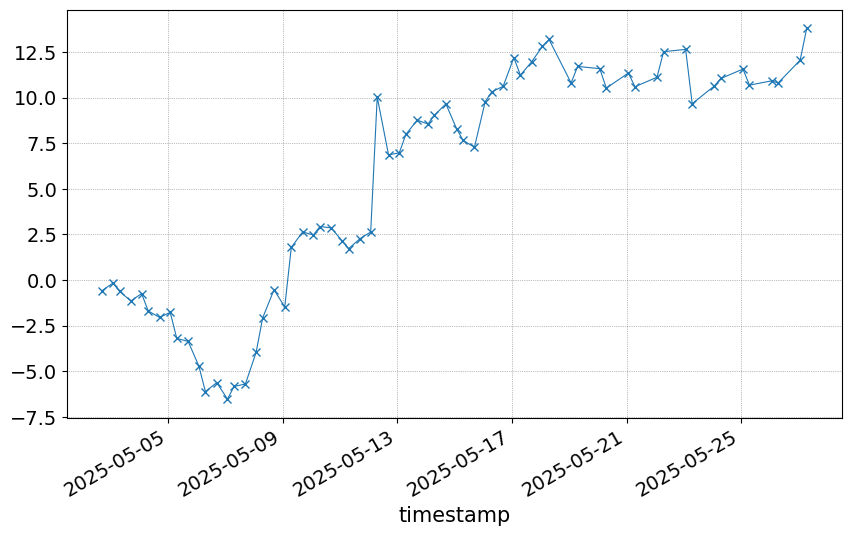

In [116]:
mat.set_index("timestamp").pl_bp.div(1e2).cumsum().plot(marker="x")

In [118]:
mat.head()

,timestamp,rdec_timestamp,sym,side,rinc_price,rdec_price,pl_bp,amount,pl,horizon,pos_before_rinc,pos_before_rdec,rinc_order_type,rdec_order_type,rinc_order_id,rdec_order_id,rinc_trade_id,rdec_trade_id
0,2025-05-02 16:30:11+00:00,2025-05-02 20:31:58+00:00,XRPJPY,1.0,323.210,321.341,-57.826181,1.0,-57.826181,14507.0,0.0,1.0,market,market,836fdaed8c2b40c5a9a2f330b8949420,69b7e2cd6cdb4d8682267b46616361d0,f34e63d4c6d24074ad0aa4147e9d3959,78f4f35150f74c589ab156455e6a15bf
1,2025-05-03 01:32:06+00:00,2025-05-03 05:31:08+00:00,XRPJPY,1.0,320.116,321.428,40.985143,1.0,40.985143,14342.0,0.0,1.0,market,market,650145c5df1e4fe98e748e57f69c73c4,464f2ed6ee00422f95c2b3b1c614ccef,f497262b6dde41c7b5edca5802dd24b9,66c792d6190b475cbde0ec574acef0d7
2,2025-05-03 07:00:18+00:00,2025-05-03 12:32:00+00:00,XRPJPY,1.0,320.790,319.329,-45.543814,1.0,-45.543814,19902.0,0.0,1.0,market,market,2f75f3dbf2d64e72adcb958bcdc1a274,59bbf35e7ab247679c5f4cc6fe966671,acbc4c11ea8549f0a2f23cfcd4baed96,6fc2f67472cb48279bb70b850fcdbfee
3,2025-05-03 16:30:52+00:00,2025-05-03 20:30:20+00:00,XRPJPY,1.0,320.859,319.170,-52.639945,1.0,-52.639945,14368.0,0.0,1.0,market,market,d654333273e24637a3917b2e4ffca061,b3495bd488e546959c40250748c489b2,cc15dbf8d36d48e28c0a54be185c6aed,24e8724e36584a8a887225a31f3897aa
4,2025-05-04 01:31:15+00:00,2025-05-04 05:30:59+00:00,XRPJPY,1.0,319.601,320.895,40.487983,1.0,40.487983,14384.0,0.0,1.0,market,market,976414e2d7814da8a0f0be6e6f293ba5,180e6fdfedd842eba15a24b6e45c2801,ace1d3144c374d9fba35fa0b69f12efc,6a444bcf0cc0435ea883f3b61da7043b
